# Case 1. Heart Disease (binary) Classification (healthy/sick)

- Author: Lauri Solin
- some code was borrowed from teacher's example (Sakari Lukkanen) 
- link to that example here https://github.com/sakluk/cognitive-systems-for-health-technology/blob/master/Week_2_Case_1_(drafty_notes).ipynb
- student miniproject about neural networks with python
- date started 29.1.2019
- organization: Metropolia University of Applied Sciences

In [101]:
# Import libraries
%pylab inline
import time
import warnings
import pandas as pd

from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from keras.utils import to_categorical
from keras import models, layers
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasClassifier

Populating the interactive namespace from numpy and matplotlib


C:\Users\Lauri\Anaconda3\envs\py36\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cm', 'shuffle', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### get the data and dataprocessing

* download preprocessed data (for simplicity) about that heart disease from the website


* use preprocessed cleveland data first

* normalize data


* maybe later combine the preprocessed data (cleveland, switzerland, hungary etc...)


* process the data so that the diseased persons are mapped from (1,2,3,4) into (1)


* process the data so that healthy persons are mapped into 0


* randomize the order of the samples in the data (just to be sure)


In [102]:
# download the data first
path1 = r'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
df = pd.read_csv(path1,
                 sep=',',
                 header = None,
                 index_col = None,
                 na_values='?')

# check the data downloaded
df.head()

# column names list
c_names = ['age', 'sex', 'cp','trestbps', 'chol', 'fbs','restecg',
             'thalac','exang','oldpeak','slope','ca','thal','num']

# put column names into the df
df.columns = c_names

# replace nan values with medians
df = df.fillna(df.median())

# recheck if nan was replaced,  seems to work, 
# because original data had some lines at the end which had nan
df.tail()



,age,sex,cp,trestbps,chol,fbs,restecg,thalac,exang,oldpeak,slope,ca,thal,num
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,0.0,3.0,0


(303, 13) (303,)
123    1.0
71     1.0
198    0.0
35     0.0
252    0.0
203    0.0
287    0.0
260    0.0
64     1.0
119    1.0
166    0.0
54     1.0
59     0.0
195    1.0
232    1.0
68     1.0
84     0.0
189    1.0
62     1.0
194    0.0
67     0.0
211    1.0
149    0.0
61     0.0
193    1.0
213    1.0
127    1.0
51     0.0
27     0.0
1      1.0
      ... 
125    0.0
223    1.0
180    1.0
128    0.0
277    0.0
263    0.0
225    0.0
113    1.0
111    1.0
73     1.0
214    1.0
256    0.0
86     0.0
227    0.0
205    1.0
274    1.0
60     1.0
103    0.0
196    0.0
296    1.0
75     0.0
238    0.0
50     0.0
233    0.0
235    1.0
192    1.0
120    1.0
32     1.0
184    1.0
163    0.0
Name: num, Length: 303, dtype: float64


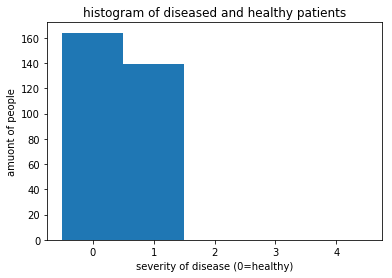

,age,sex,cp,trestbps,chol,fbs,restecg,thalac,exang,oldpeak,slope,ca,thal
192,0.291667,1.0,1.000000,0.358491,0.276256,1.0,1.0,0.549618,1.0,0.016129,0.5,0.000000,1.0
120,0.395833,1.0,1.000000,0.339623,0.296804,1.0,1.0,0.603053,1.0,0.000000,0.0,0.666667,1.0
32,0.729167,1.0,0.666667,0.433962,0.477169,0.0,0.0,0.664122,0.0,0.000000,0.0,0.000000,0.0
184,0.645833,0.0,1.000000,0.603774,0.408676,0.0,1.0,0.687023,0.0,0.000000,0.0,0.000000,0.0
163,0.604167,0.0,1.000000,0.056604,0.278539,0.0,1.0,0.389313,0.0,0.161290,0.5,0.000000,0.0


In [103]:
# randomize order of datarows (patientdata)
df = shuffle(df)

# normalize data with regard to min and max values
data_min = df.min()
data_max = df.max()
df_norm = (df - data_min)/(data_max - data_min)

# remap the diseased into a single category (healthy=0/sick=1)
# this is the output column (labels)
groundTruth = df_norm['num']
groundTruth = 1.0*(groundTruth > 0.0) 



# I guess, you could just drop the column from the df_norm, just to be sure
# so that df_norm has only the input columns for training & validation
df_norm.drop('num', axis=1, inplace=True)

# check the shapes and values look ok for the dropped labels from df_norm
# and also for the binary labels in the groundTruth series
print(df_norm.shape, groundTruth.shape)
print(groundTruth)

# histogram should have only O's and 1's inside of it
plt.hist(groundTruth, bins = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
plt.xlabel('severity of disease (0=healthy)')
plt.ylabel('amuont of people')
plt.title('histogram of diseased and healthy patients')
plt.show()

# as can be seen just as a note the df_norm, we dropped that label column
df_norm.tail()

 ## Prepare to train the model
 
 * first, I use cleveland data, and we must divide into training and validation sets
 * first, I use regular validation and training style
 
 * secondly I will try cross-validation with Kfolds with given example code to see if there is much differences if the model is the same
 
 * I will attempt to start from chollet book chapter_4, using 
     1. relu activation
     2. sigmoid at final layer
     3. 16 neuron, 2  layer
     4. optimizers testing two choices adam vs rmsprop
     5. if there is overfitting, change layer dropouts with different rates

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 16)                224       
_________________________________________________________________
dense_53 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 17        
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________
Elapsed time: 6.44 seconds


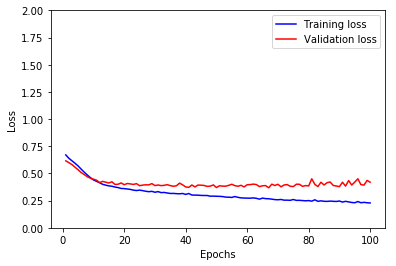

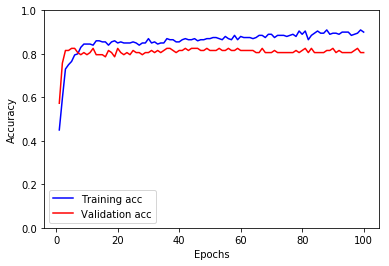

In [104]:
# df_norm should be already randomized & normalized
train_data = df_norm[:200]
validate_data = df_norm[200:]

# get labels from groundTruth series
# OneHotLabels should not be necessary as it is binary classification
train_labels = groundTruth[:200]
validate_labels = groundTruth[200:]

# build model according to basic format from chollets chapter_4 bin_classification
# of IMDB- movie reviews
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(13,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

# Compile the model
model.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])


# traing the model
t_start = time.time()
history = model.fit(train_data, train_labels, 
                    epochs = 100,
                    batch_size = 5,
                    verbose = 0,
                    validation_data = (validate_data, validate_labels))

t_end = time.time()


print('Elapsed time: {:.2f} seconds'.format(t_end - t_start))

# Get the training data
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(loss_values) + 1)


# Visualize the training process: loss function
plt.figure()
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend()
plt.show()


# Visualize the accuracy
plt.figure()
plt.plot(epochs, acc_values, 'b', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()





In [105]:
# Print total accuracy and confusion matrix
val_predicts = model.predict(df_norm)
y_pred = argmax(val_predicts, axis = 1)



cm = confusion_matrix(groundTruth, y_pred)

print(val_predicts)
print(y_pred)
print(cm)

# here we have simple check where we assume that all people are healthy
# then, we check what probability we get with dumb guess

# Normal cases can be counted by summing all labels that are zeros
print('Best guess: {:.4f}'.format(np.sum(groundTruth == 0)/len(groundTruth)))

# Accuracy can be calculated from the confusion matrix by
# counting all elements in diagonal (=trace of the matrix)
print('Total accuracy: {:.4f}'.format(np.trace(cm)/sum(cm)))
print('Confusion matrix:')
print(cm)



# Calculate precision, recall, fscore and support
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    p, r, f, s = precision_recall_fscore_support(groundTruth, y_pred)

# Print precision, recall, fscore and support  
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print('Support:\n', s)
print('Precision:', p)
print('Recall:   ', r)
print('F-score:  ', f)

# We should do something in order to get the accuracy better, but what?


[[ 1.000]
 [ 0.439]
 [ 0.009]
 [ 0.030]
 [ 0.886]
 [ 0.049]
 [ 0.173]
 [ 0.053]
 [ 0.927]
 [ 0.972]
 [ 0.025]
 [ 0.852]
 [ 0.106]
 [ 0.940]
 [ 0.956]
 [ 0.998]
 [ 0.074]
 [ 0.978]
 [ 0.998]
 [ 0.057]
 [ 0.372]
 [ 0.953]
 [ 0.030]
 [ 0.116]
 [ 0.992]
 [ 0.995]
 [ 0.995]
 [ 0.112]
 [ 0.115]
 [ 0.999]
 [ 0.006]
 [ 0.503]
 [ 0.020]
 [ 0.044]
 [ 0.159]
 [ 0.998]
 [ 0.761]
 [ 0.433]
 [ 0.056]
 [ 0.564]
 [ 0.829]
 [ 0.015]
 [ 0.079]
 [ 0.998]
 [ 0.976]
 [ 0.132]
 [ 0.116]
 [ 0.922]
 [ 0.007]
 [ 0.017]
 [ 0.999]
 [ 1.000]
 [ 0.131]
 [ 0.027]
 [ 0.695]
 [ 0.461]
 [ 0.024]
 [ 0.008]
 [ 0.042]
 [ 0.280]
 [ 0.029]
 [ 0.523]
 [ 0.981]
 [ 0.247]
 [ 0.105]
 [ 0.094]
 [ 0.625]
 [ 0.998]
 [ 0.041]
 [ 0.055]
 [ 0.563]
 [ 0.066]
 [ 0.951]
 [ 0.838]
 [ 0.222]
 [ 0.087]
 [ 0.972]
 [ 0.008]
 [ 0.443]
 [ 0.712]
 [ 0.010]
 [ 0.418]
 [ 0.997]
 [ 0.805]
 [ 0.746]
 [ 0.960]
 [ 0.009]
 [ 0.088]
 [ 0.007]
 [ 0.992]
 [ 0.987]
 [ 0.246]
 [ 0.455]
 [ 0.006]
 [ 0.011]
 [ 0.525]
 [ 0.578]
 [ 0.635]
 [ 0.764]
 [ 0.167]
